In [1]:
from tqdm import tqdm, tqdm_notebook
import os
import os.path
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn

import torchvision.transforms as transforms
import torchvision.models as models

from csfnst.utils import rename_network_layers, replace_network_layers, load_image
# from csfnst.losses import PerceptualLoss

from IPython.core.display import display, HTML
from time import time
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

force_cpu = False
device = torch.device('cuda' if torch.cuda.is_available() and not force_cpu else 'cpu')
content_image_size = 1024
style_image_size = 1024
content_weight = 1
style_weights = [1e9]
#style_weights = [0]
total_variation_weights = [0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]

style_image_file = '../images/style/the_scream.jpg'
content_image_file = '../images/content/htw.jpg'

style_image = load_image(style_image_file, size=style_image_size, normalize=False).to(device)
content_image = load_image(content_image_file, size=content_image_size, normalize=False).to(device)

# '../images/content/brad_pitt_01.jpg',
# '../images/content/golden_gate_01.jpg',
# '/home/christoph/.datasets/coco_super_tiny/train/COCO_test2014_000000000155.jpg',
# '/home/christoph/.datasets/coco_super_tiny/train/COCO_test2014_000000000229.jpg'
# '../images/content/hoovertowernight_01.jpg',
# '../images/content/tubingen_01.jpg'

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from csfnst.utils import extract_activation_maps, gram_matrix


class PerceptualLoss(nn.Module):
    def __init__(
            self,
            model,
            content_layers,
            style_layers,
            style_image,
            content_weight=1,
            style_weight=1e7,
            total_variation_weight=0,
            normalize_gram=True,
            content_loss_history=None,
            style_loss_history=None,
            total_variation_loss_history=None,
            loss_history=None,
            multiplier=1
    ):
        super(PerceptualLoss, self).__init__()

        self.model = model
        self.content_layers = content_layers
        self.style_layers = style_layers
        self.normalize_gram = normalize_gram
        self.content_weight = content_weight
        self.style_weight = style_weight
        self.total_variation_weight = total_variation_weight

        self.content_loss_history = content_loss_history if content_loss_history else []
        self.style_loss_history = style_loss_history if style_loss_history else []
        self.total_variation_loss_history = total_variation_loss_history if total_variation_loss_history else []
        self.loss_history = loss_history if loss_history else []
        self.multiplier = multiplier

        style_features = extract_activation_maps(
            style_image.unsqueeze(0) * multiplier,
            self.model,
            style_layers,
            detach=True
        )

        self.style_grams = [gram_matrix(style_feature, self.normalize_gram) for style_feature in style_features]

    def forward(self, generated_images, input_images):
        input_images = input_images * self.multiplier
        generated_images = generated_images * self.multiplier

        if generated_images.shape != input_images.shape:
            input_images = F.interpolate(input_images, size=(generated_images.shape[2], generated_images.shape[3]))

        content_loss = self.content_weight * self.content_loss(generated_images, input_images)
        style_loss = self.style_weight * self.style_loss(generated_images)
        total_variation_loss = self.total_variation_weight * self.total_variation_loss(generated_images)
        loss = content_loss + style_loss + total_variation_loss

        self.content_loss_history.append(content_loss)
        self.style_loss_history.append(style_loss)
        self.total_variation_loss_history.append(total_variation_loss)
        self.loss_history.append(loss)

        return loss

    def content_loss(self, generated_images, input_images):
        generated_features = extract_activation_maps(generated_images, self.model, self.content_layers)
        input_features = extract_activation_maps(input_images, self.model, self.content_layers, detach=True)

        return sum([
            F.mse_loss(
                generated_feature,
                input_feature
            )
            for generated_feature, input_feature in zip(generated_features, input_features)
        ])

    def style_loss(self, generated_images):
        generated_features = extract_activation_maps(generated_images, self.model, self.style_layers)
        generated_grams = [
            gram_matrix(generated_feature, self.normalize_gram)
            for generated_feature in generated_features
        ]

        return sum([
            F.mse_loss(
                generated_gram,
                style_gram
            )
            for generated_gram, style_gram in zip(generated_grams, self.style_grams)
        ])

    def total_variation_loss(self, generated_images):
        return torch.add(
            torch.sum(torch.abs(generated_images[:, :, :, :-1] - generated_images[:, :, :, 1:])),
            torch.sum(torch.abs(generated_images[:, :, :-1, :] - generated_images[:, :, 1:, :]))
        )


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


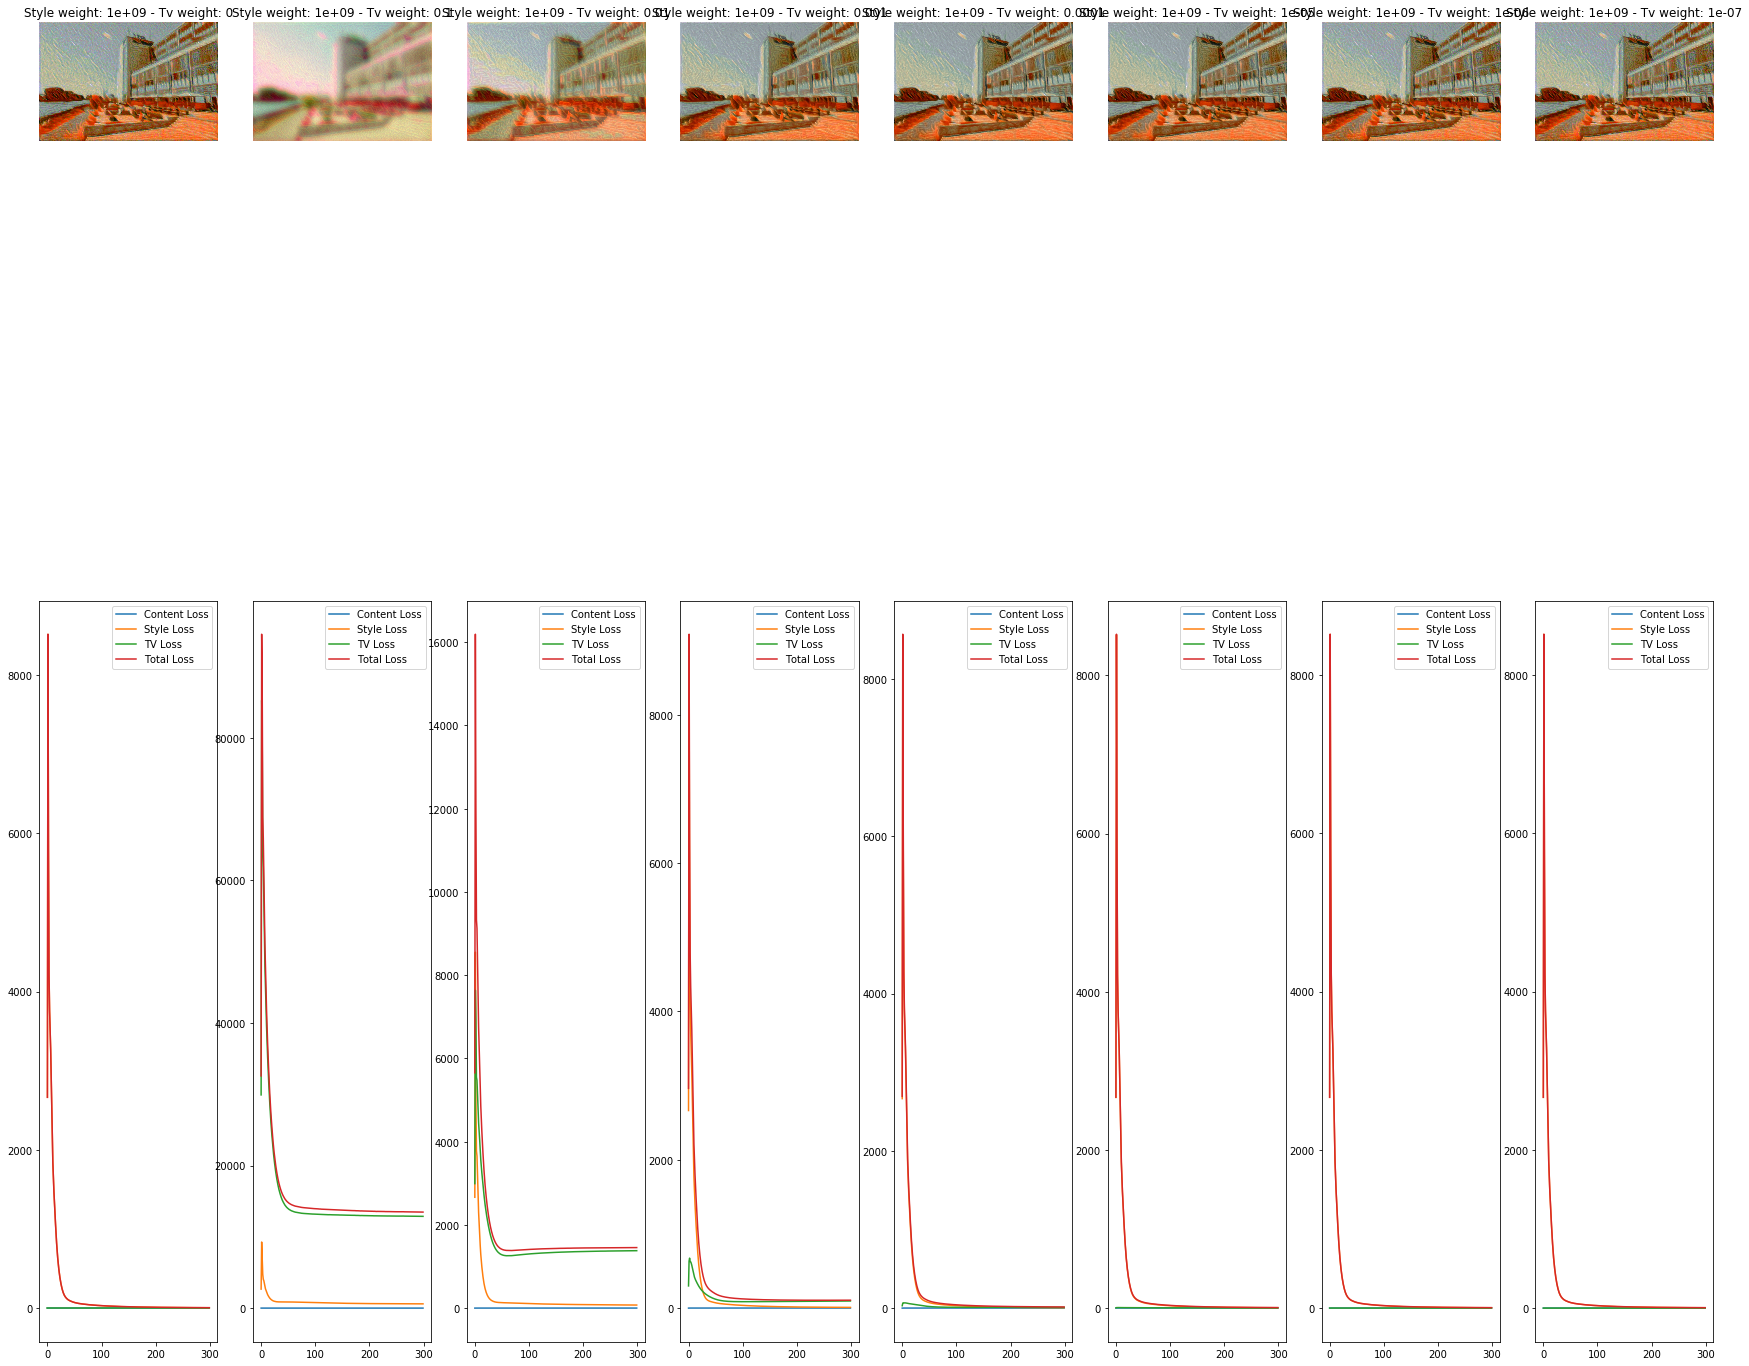

In [3]:
def run_style_transfer_slow(
    style_image,
    content_image, 
    use_lbfgs, 
    epochs, 
    device,
    content_weight,
    style_weight,
    total_variation_weight
):    
    output_image = content_image.clone().to(device).unsqueeze(0)
    content_image = content_image.unsqueeze(0)
    output_image.requires_grad_()

    
    loss_network = rename_network_layers(
        replace_network_layers(
            models.vgg16(pretrained=True).features.to(device).eval()[:23],
            'MaxPool2d',
            'AvgPool2d'
        )
    ).to(device).eval()

    criterion = PerceptualLoss(
        model=loss_network,
        content_layers=['relu3_3'],
        style_layers=['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'],
        style_image=style_image,    
        content_weight=content_weight,
        style_weight=style_weight,
        total_variation_weight=total_variation_weight,
        normalize_gram=True,
        multiplier=1
    )

    optimizer = optim.LBFGS([output_image]) if use_lbfgs else optim.Adam([output_image], lr=1e-1)

    progress_bar = tqdm_notebook(range(epochs))
    
    if use_lbfgs:
        for epoch in progress_bar:
            def closure():
                output_image.data.clamp_(0, 1)
                optimizer.zero_grad()

                loss = criterion(output_image, content_image)
                loss.backward()

                progress_bar.set_description(f'Loss: {loss.item():,.2f}')

                return loss

            optimizer.step(closure)
    else:
        for epoch in progress_bar:
            output_image.data.clamp_(0, 1)
            optimizer.zero_grad()

            loss = criterion(output_image, content_image)
            loss.backward()

            progress_bar.set_description(f'Loss: {loss.item():,.2f}')

            optimizer.step()
            
    output_image.data.clamp_(0, 1)
    
    return criterion.content_loss_history, criterion.style_loss_history, criterion.total_variation_loss_history, \
        criterion.loss_history, output_image.squeeze()


####

fig, axes = plt.subplots(len(style_weights) * 2, len(total_variation_weights), figsize=(30, 30), squeeze=False)

for i, style_weight in enumerate(style_weights):
    for o, total_variation_weight in enumerate(total_variation_weights):
        cl_hist, sl_hist, tvl_hist, l_hist, output_image = run_style_transfer_slow(
            style_image=style_image, 
            content_image=content_image, 
            device=device,
            use_lbfgs=False,
            epochs=300,
            content_weight=1,
            style_weight=style_weight,
            total_variation_weight=total_variation_weight
        )
        
        
        output = transforms.ToPILImage()(output_image.cpu())
        
        axes[i * 2, o].title.set_text(f'Style weight: {style_weight:1.0g} - Tv weight: {total_variation_weight:1.0g}')
        axes[i * 2, o].imshow(output, interpolation='none')
        axes[i * 2, o].axis('off')
        
        axes[i * 2 + 1, o].plot(cl_hist, label=f'Content Loss')
        axes[i * 2 + 1, o].plot(sl_hist, label=f'Style Loss')
        axes[i * 2 + 1, o].plot(tvl_hist, label=f'TV Loss')
        axes[i * 2 + 1, o].plot(l_hist, label=f'Total Loss')
        axes[i * 2 + 1, o].legend()
        
fig.savefig('../images/output/test_losses.png', dpi=300)
display(HTML('<a href="/tree/images/output/test_losses.png">/tree/images/output/test_losses.png</a>'))